# 1. IMPORTS
### Load all necessary libraries for data manipulation, visualization, modeling, and evaluation.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, roc_auc_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


# 2. LOAD AND CLEAN DATA
### Load the dataset, handle missing values, encode categories, create target and new features.


In [21]:
df = pd.read_csv("sample_data/dataset_Facebook.csv", sep=";")

# Fill missing values
df['Paid'].fillna(0, inplace=True)
df['like'].fillna(df['like'].median(), inplace=True)
df['share'].fillna(df['share'].median(), inplace=True)

# Create binary target
df['Engaged'] = (df['Total Interactions'] > df['Total Interactions'].median()).astype(int)

# One-hot encode 'Type'
df = pd.get_dummies(df, columns=['Type'], drop_first=True)

# Feature engineering: engagement rate
df['Engagement_Rate'] = (df['like'] + df['share'] + df['comment']) / df['Page total likes']


<ipython-input-21-1175527737>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Paid'].fillna(0, inplace=True)
<ipython-input-21-1175527737>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col:

# 3. VISUALIZE FEATURE DISTRIBUTIONS
### View distribution shapes of key numeric features using histograms with density overlays.

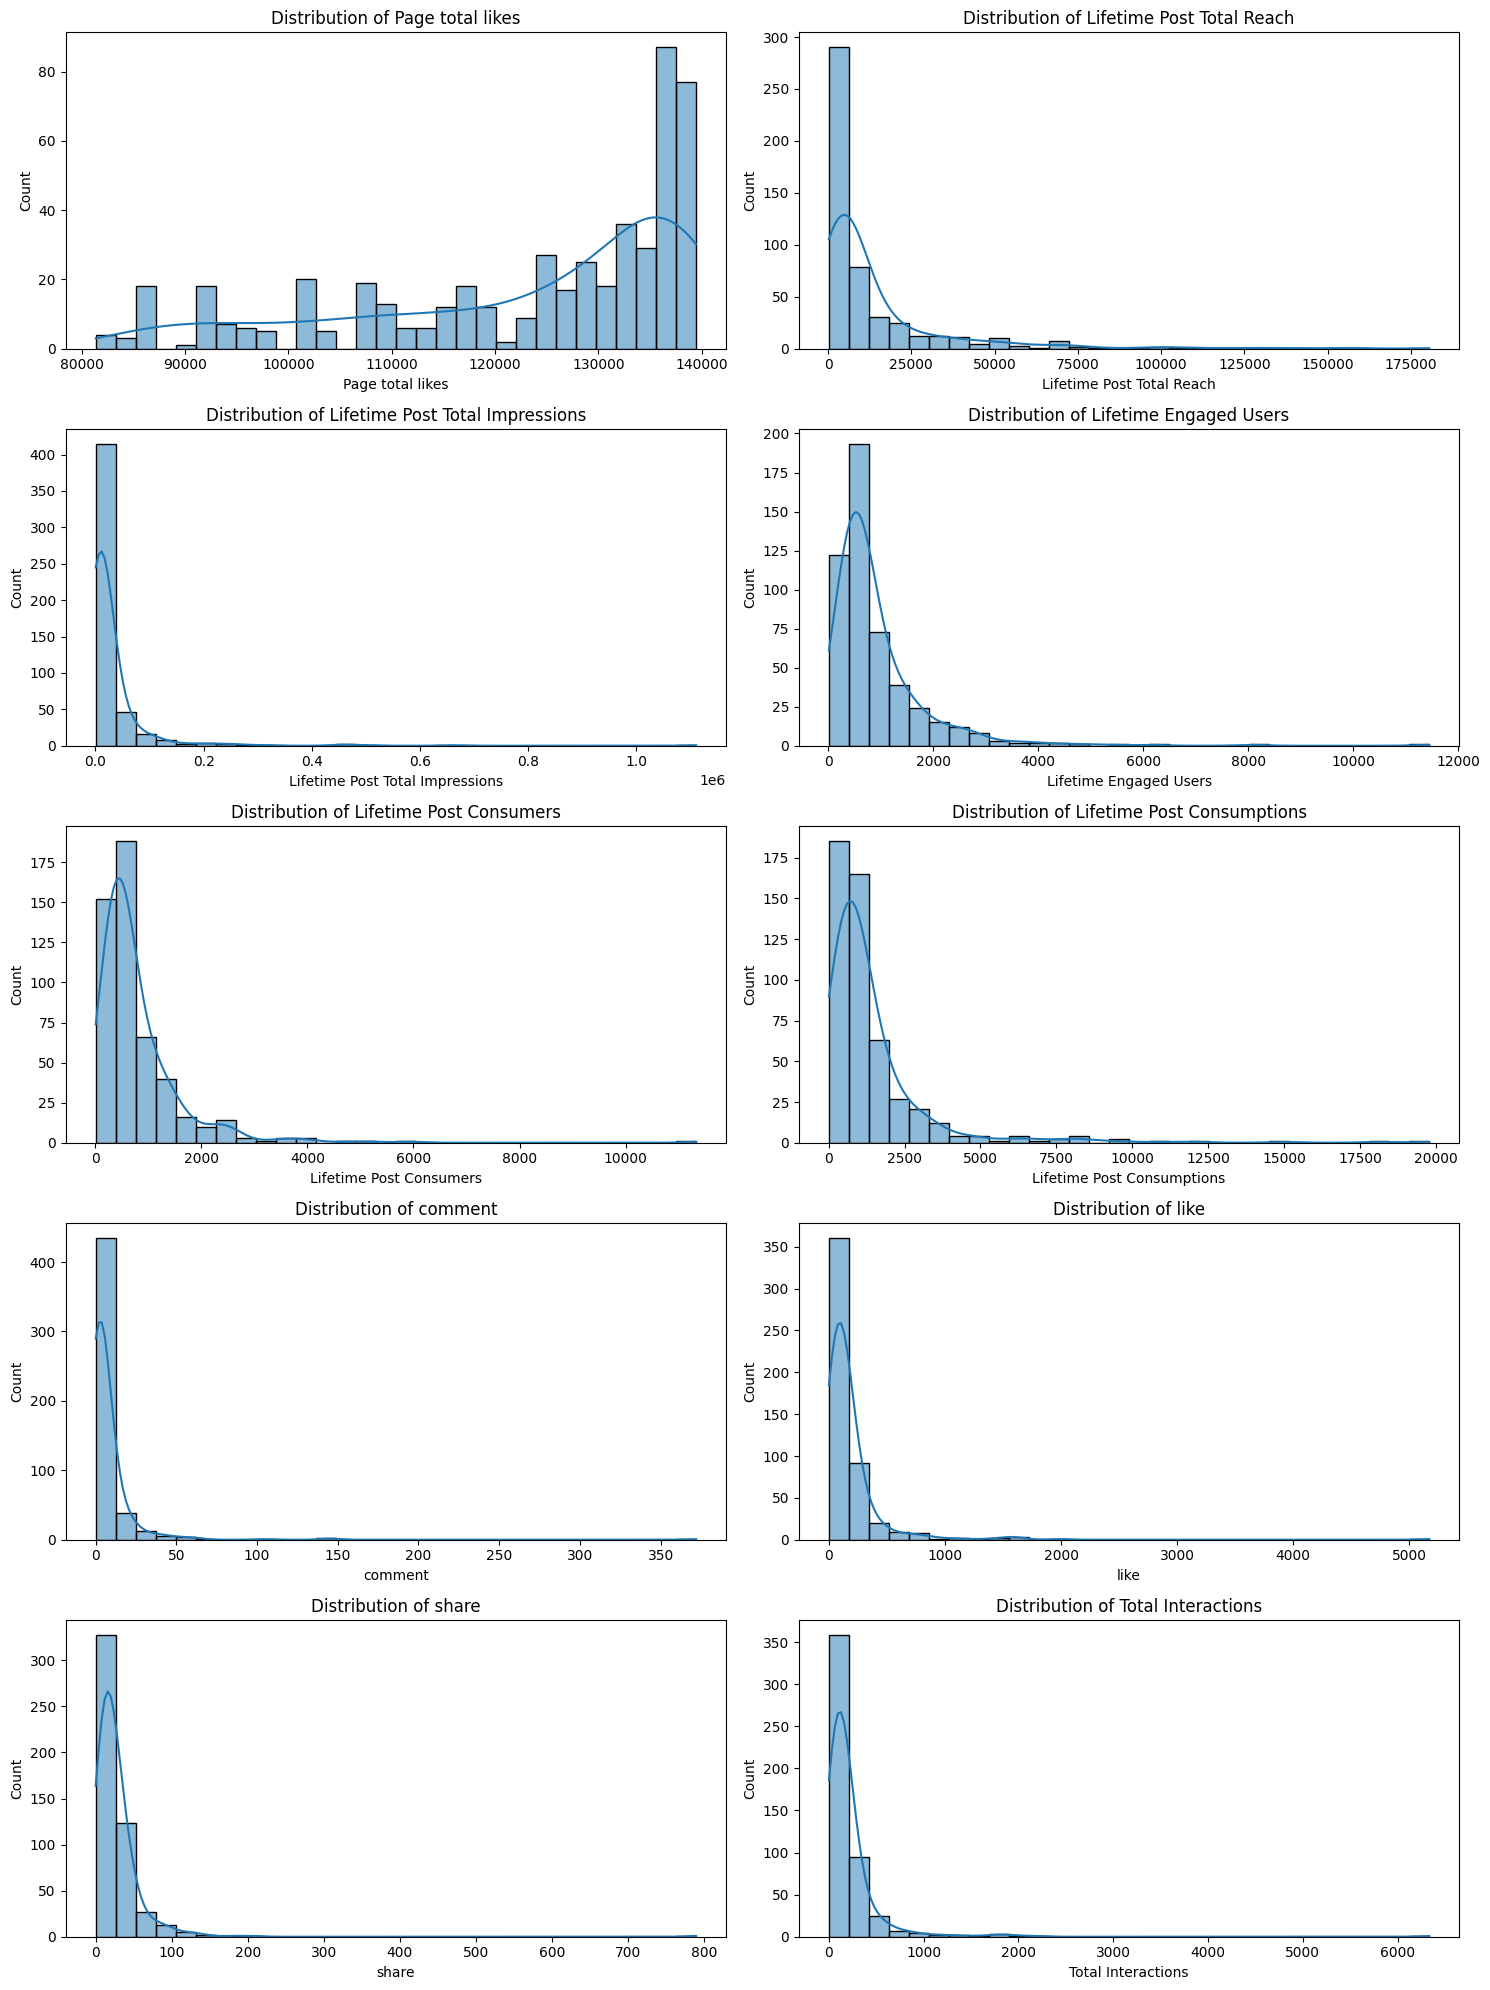

In [22]:
numeric_cols = [
    'Page total likes', 'Lifetime Post Total Reach', 'Lifetime Post Total Impressions',
    'Lifetime Engaged Users', 'Lifetime Post Consumers', 'Lifetime Post Consumptions',
    'comment', 'like', 'share', 'Total Interactions'
]

plt.figure(figsize=(15, 20))
for i, col in enumerate(numeric_cols):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()


#  4. SPLIT AND SCALE DATA
### Prepare the data for modeling by separating features/target and scaling.

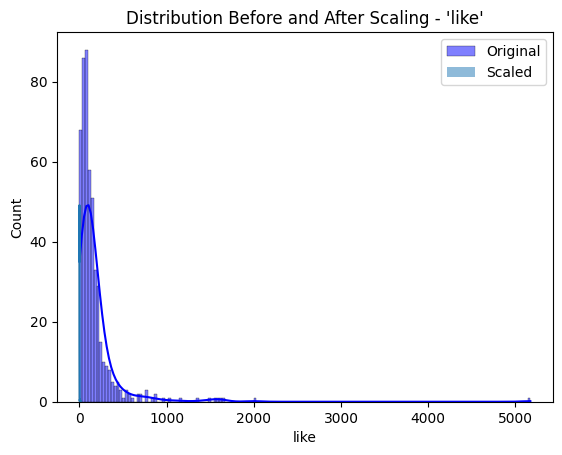

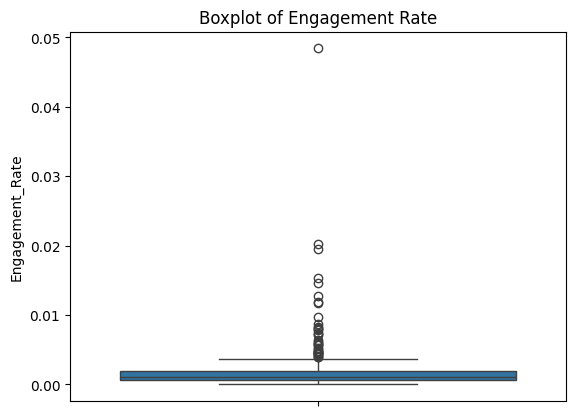

In [36]:
X = df.drop(columns=['Total Interactions', 'Engaged'])
y = df['Engaged']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# Scaling visual example for 1 feature
sns.histplot(df['like'], kde=True, color='blue', label='Original')
sns.histplot(StandardScaler().fit_transform(df[['like']]), kde=True, color='orange', label='Scaled')
plt.title("Distribution Before and After Scaling - 'like'")
plt.legend()
plt.show()
# Boxplot of Engagement Rate
sns.boxplot(data=df, y='Engagement_Rate')
plt.title("Boxplot of Engagement Rate")
plt.show()



# 5. BASELINE MODELING
### Train and evaluate four base classifiers to establish benchmark performance.

In [25]:
baseline_models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True)
}

baseline_results = {}

for name, model in baseline_models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    baseline_results[name] = f1_score(y_test, y_pred)
    print(f"\n{name} Report:")
    print(classification_report(y_test, y_pred))
    print("ROC-AUC:", roc_auc_score(y_test, y_proba))



Logistic Regression Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        51
           1       1.00      0.88      0.93        49

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

ROC-AUC: 0.9955982392957182

Decision Tree Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        51
           1       1.00      0.88      0.93        49

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

ROC-AUC: 0.9387755102040816

Random Forest Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        51
           1       1.00      0.94      0.97        49

    accuracy                           0.97       1

# 6. HYPERPARAMETER TUNING (RANDOM FOREST)
### Use GridSearchCV to find best Random Forest parameters and re-evaluate performance.

In [26]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, scoring='f1', cv=5)
grid.fit(X_train_scaled, y_train)
best_rf = grid.best_estimator_

y_pred_rf = best_rf.predict(X_test_scaled)
y_proba_rf = best_rf.predict_proba(X_test_scaled)[:, 1]

print("\nTuned Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))

baseline_results["Tuned RF"] = f1_score(y_test, y_pred_rf)



Tuned Random Forest Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        51
           1       1.00      0.94      0.97        49

    accuracy                           0.97       100
   macro avg       0.97      0.97      0.97       100
weighted avg       0.97      0.97      0.97       100

ROC-AUC: 0.9951980792316927


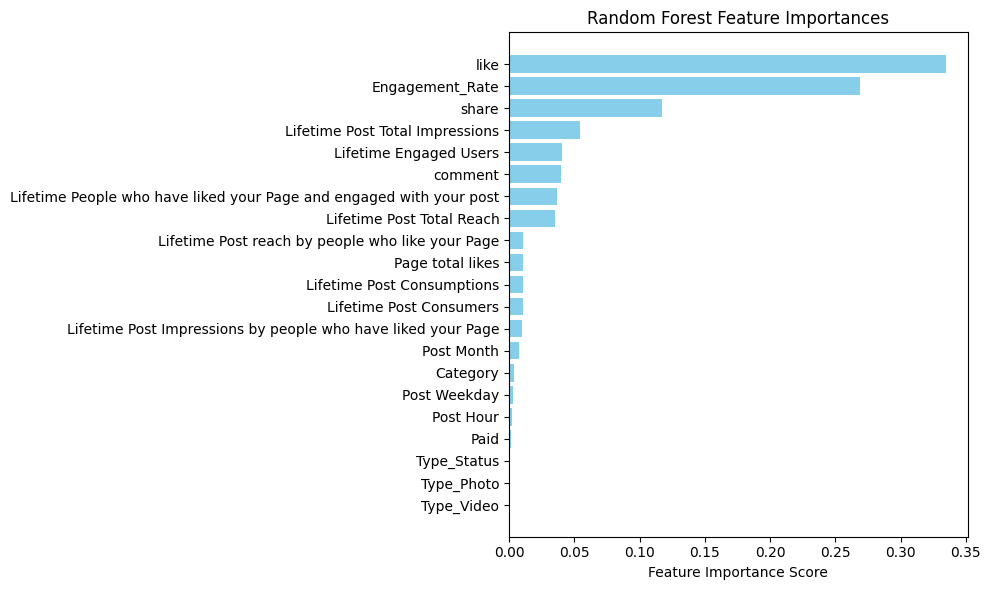

In [37]:
# Random Forest Feature Importance Bar Chart
importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_rf.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importances['Feature'], importances['Importance'], color='skyblue')
plt.xlabel("Feature Importance Score")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 7. LINEAR DISCRIMINANT ANALYSIS (LDA)
### Reduce the dimensionality of the feature space to 1 component and retrain using Random Forest.

In [27]:
lda = LDA(n_components=1)
X_train_lda = lda.fit_transform(X_train_scaled, y_train)
X_test_lda = lda.transform(X_test_scaled)

rf_lda = RandomForestClassifier(random_state=42)
rf_lda.fit(X_train_lda, y_train)
y_pred_lda_rf = rf_lda.predict(X_test_lda)
y_proba_lda_rf = rf_lda.predict_proba(X_test_lda)[:, 1]

baseline_results["LDA + RF"] = f1_score(y_test, y_pred_lda_rf)

print("\nLDA + Random Forest Report:")
print(classification_report(y_test, y_pred_lda_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lda_rf))



LDA + Random Forest Report:
              precision    recall  f1-score   support

           0       0.70      0.78      0.74        51
           1       0.74      0.65      0.70        49

    accuracy                           0.72       100
   macro avg       0.72      0.72      0.72       100
weighted avg       0.72      0.72      0.72       100

ROC-AUC: 0.78531412565026


# 8. HYPERPARAMETER TUNING (SVM)
### Perform a grid search to find the best SVM kernel and regularization parameters.

In [28]:
svm_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_tuner = GridSearchCV(SVC(probability=True), svm_grid, cv=5, scoring='f1')
svm_tuner.fit(X_train_scaled, y_train)
best_svm = svm_tuner.best_estimator_

y_pred_svm_tuned = best_svm.predict(X_test_scaled)
y_proba_svm_tuned = best_svm.predict_proba(X_test_scaled)[:, 1]

baseline_results["Tuned SVM"] = f1_score(y_test, y_pred_svm_tuned)

print("\nTuned SVM Report:")
print(classification_report(y_test, y_pred_svm_tuned))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_svm_tuned))



Tuned SVM Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        51
           1       1.00      0.90      0.95        49

    accuracy                           0.95       100
   macro avg       0.96      0.95      0.95       100
weighted avg       0.95      0.95      0.95       100

ROC-AUC: 0.9975990396158464


# 9. FEATURE IMPORTANCE (SHAP)
### Interpret the Random Forest model using SHAP values for class 1 (Engaged = 1).

In [47]:
import shap
import matplotlib.pyplot as plt

# Convert X_train to DataFrame if not already
X_train_df = pd.DataFrame(X_train, columns=X.columns)

# Refit model on unscaled data
best_rf_unscaled = RandomForestClassifier(**best_rf.get_params())
best_rf_unscaled.fit(X_train, y_train)

# SHAP explanation
explainer = shap.TreeExplainer(best_rf_unscaled)
shap_values = explainer.shap_values(X_train_df)  # shape: (n_samples, n_features, 2)

# Save SHAP summary plot for class 1 (Engaged = class index 1)
shap.summary_plot(shap_values[:, :, 1], X_train_df, show=False)  # Do NOT wrap in plt.figure()
plt.savefig("shap_summary_plot_class2.png", bbox_inches='tight', dpi=300)
plt.close()


# 10. MODEL COMPARISON CHART
### Visualize and compare the F1 scores of all trained models to determine the top performer.

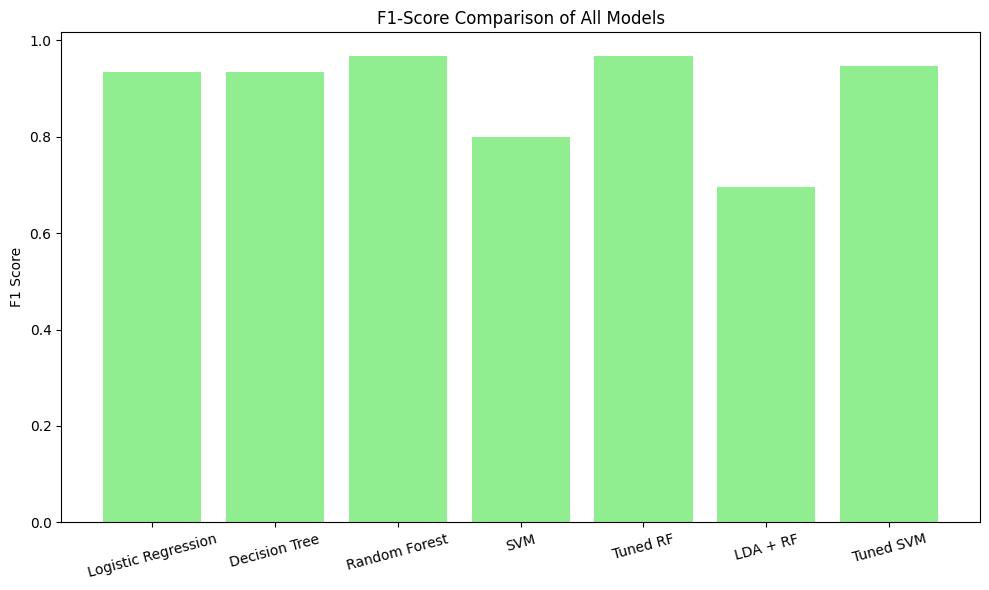

In [33]:
plt.figure(figsize=(10,6))
plt.bar(baseline_results.keys(), baseline_results.values(), color='lightgreen')
plt.title("F1-Score Comparison of All Models")
plt.ylabel("F1 Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
